In [1]:
import sys, os
sys.path.insert(0, os.path.abspath("../pyCudaPolygon"))
import pyCudaPolygon as pcp
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import numpy as np

def random_convex_polygon(lengths, seed = None):
    rng = np.random.default_rng(seed)
    lengths = np.asarray(lengths, dtype=float)
    n = len(lengths)

    # Polygon inequality
    if np.max(lengths) > np.sum(lengths) - np.max(lengths):
        raise ValueError("Side lengths violate polygon inequality.")

    # Random turning angles summing to 2π
    turns = rng.dirichlet(np.ones(n)) * 2 * np.pi
    # Make the first turn 0
    turns = np.pi - turns
#    turns -= turns[0]
    return turns[1:]

    # Absolute directions
    angles = (np.arange(n) + 1) * np.pi - np.cumsum(turns)
#    angles = np.cumsum(turns)

    # Edge vectors
    dx = lengths * np.cos(angles)
    dy = lengths * np.sin(angles)

    # Vertices
    x = np.concatenate([[0], np.cumsum(dx)])
    y = np.concatenate([[0], np.cumsum(dy)])

    # Remove duplicate endpoint
    return x[:-1], y[:-1]


In [3]:
n = 50
m = pcp.model(size = n, seed = 3)
m.setModelEnum("normal")
#totalInternalAngle
theta = random_convex_polygon(np.ones(n), seed = 3)
# Get random side lengths. Let's make them all one
l = np.ones(n)

In [4]:
x, y = m.getVertices(theta, l * 1).T

In [5]:
np.sum(theta) / np.pi

47.00427129907553

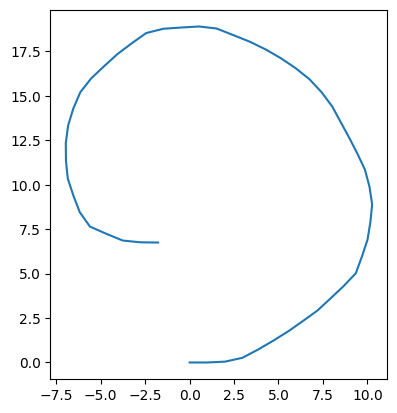

In [6]:
plt.plot(x, y)
plt.gca().set_aspect(1)

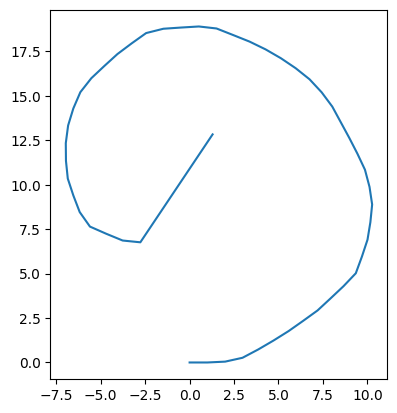

In [7]:
# Now for testing purposes, make the last edge go between the final two points
#(x[-1], y[-1]) = -v[-1]
lFinal = np.sqrt(x[-2]**2 + y[-2]**2)
v1 = np.array([-x[-2], -y[-2]])
v2 = np.array([x[-3] - x[-2], y[-3] - y[-2]])
theta[-1] = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
l[-1] = lFinal
x2, y2 = m.getVertices(theta, l).T
plt.plot(x2, y2)
plt.gca().set_aspect(1)

In [8]:
# Now we get the proper area:
np.dot((np.roll(y2, -1) - y2), (np.roll(x2, -1) + x2)) / 2

203.04367319812158

In [9]:
m.area(theta, l)

211.34397082432696

In [10]:
numPolygons = 4
n = 50
m = pcp.model(size = n * numPolygons, seed = 4)
m.setModelEnum("normal")
x, y, l1, l2 = m.generateRandomPolygon(n, 4.2, numSteps = 100, tol = 1e-15)
plt.plot(x, y)
plt.show()

AttributeError: 'model' object has no attribute 'generateRandomPolygon'

In [ ]:
print(m.getShapeIndex(x, y), m.area(x, y))

In [ ]:
# We took 0 steps. Let's get L and its derivative:
epsilon = 1e-8
n = x.size
vx = x + 2 * (m.rng.random() - 0.5) * epsilon
vy = y + 2 * (m.rng.random() - 0.5) * epsilon
l = m.rng.random(n) - 0.5
lnp1 = m.rng.random() - 0.5
#l *= 0
#lnp1 *= 0
#l[0] = 1
#l[1:] = 0
kappa = 4.26
a0 = 0.093
g0 = m.g(vx, vy, kappa, a0)
dg0 = m.dg(vx, vy)
L0 = m.L(vx, vy, x, y, l, lnp1, kappa, a0)
DL = m.dL(vx, vy, x, y, l, lnp1, kappa, a0)

In [ ]:
# Let's check this derivative first:
DLNum = np.zeros((3 * n + 1))
for i in range(n):
    vxPert = vx.copy()
    vxPert[i] += epsilon
    DLNum[2 * i] = (m.L(vxPert, vy, x, y, l, lnp1, kappa, a0) - L0) / epsilon
for j in range(n):
    vyPert = vy.copy()
    vyPert[j] += epsilon
    DLNum[2 * j + 1] = (m.L(vx, vyPert, x, y, l, lnp1, kappa, a0) - L0) / epsilon
for k in range(n):
    lPert = l.copy()
    lPert[k] += epsilon
    DLNum[2 * n + k] = (m.L(vx, vy, x, y, lPert, lnp1, kappa, a0) - L0) / epsilon
lnp1Pert = lnp1
lnp1Pert += epsilon
DLNum[3 * n] = (m.L(vx, vy, x, y, l, lnp1Pert, kappa, a0) - L0) / epsilon

In [ ]:
DL - DLNum

In [ ]:
# Let's check this derivative first:
DgNum = np.zeros((n, n, 2))
for j in range(n):
    for i in range(n):
        vxPert = vx.copy()
        vxPert[i] += epsilon
        DgNum[j][i][0] = (m.g(vxPert, vy, kappa, a0)[j] - g0[j]) / epsilon
        vyPert = vy.copy()
        vyPert[i] += epsilon
        DgNum[j][i][1] = (m.g(vx, vyPert, kappa, a0)[j] - g0[j]) / epsilon

In [ ]:
np.max(np.abs(DgNum - dg0))

In [ ]:
# The first derivative is fine. What about the second derivative?

In [ ]:
def perturb(vx, vy, a, b, s1, s2, eps):
    if a:
        vy[i] += eps * s1
    else:
        vx[i] += eps * s1
    if b:
        vy[j] += eps * s2
    else:
        vx[j] += eps * s2
    return vx, vy

In [ ]:
def differenceL(vx, vy, x, y, l, lnp1, kappa, a0, eps, i, j, a, b):
    n = vx.size
    vx2, vy2 = perturb(vx, vy, a, b, 1, 1, eps)
    t1 = m.L(vx2, vy2, x, y, l, lnp1, kappa, a0)
    vx2, vy2 = perturb(vx, vy, a, b, 0, -2, eps)
    t2 = m.L(vx2, vy2, x, y, l, lnp1, kappa, a0)
    vx2, vy2 = perturb(vx, vy, a, b, -2, 2, eps)
    t3 = m.L(vx2, vy2, x, y, l, lnp1, kappa, a0)
    vx2, vy2 = perturb(vx, vy, a, b, 0, -2, eps)
    t4 = m.L(vx2, vy2, x, y, l, lnp1, kappa, a0)
    vx2, vy2 = perturb(vx2, vy, a, b, 1, 1, eps)
    return (t1 - t2 - t3 + t4) / (4 * eps * eps)

In [ ]:
def differenceg(vx, vy, x, y, l, lnp1, kappa, a0, eps, i, j, a, b):
    n = vx.size
    vx2, vy2 = perturb(vx, vy, a, b, 1, 1, eps)
    t1 = m.g(vx2, vy2, kappa, a0)
    vx2, vy2 = perturb(vx, vy, a, b, 0, -2, eps)
    t2 = m.g(vx2, vy2, kappa, a0)
    vx2, vy2 = perturb(vx, vy, a, b, -2, 2, eps)
    t3 = m.g(vx2, vy2, kappa, a0)
    vx2, vy2 = perturb(vx, vy, a, b, 0, -2, eps)
    t4 = m.g(vx2, vy2, kappa, a0)
    return (t1 - t2 - t3 + t4) / (4 * eps * eps)

In [ ]:
def differenceA(vx, vy, x, y, l, lnp1, kappa, a0, eps, i, j, a, b):
    n = vx.size
    vx, vy = perturb(vx, vy, a, b, 1, 1, eps)
    t1 = m.area(vx, vy)
    vx, vy = perturb(vx, vy, a, b, 0, -2, eps)
    t2 = m.area(vx, vy)
    vx, vy = perturb(vx, vy, a, b, -2, 2, eps)
    t3 = m.area(vx, vy)
    vx, vy = perturb(vx, vy, a, b, 0, -2, eps)
    t4 = m.area(vx, vy)
    vx, vy = perturb(vx, vy, a, b, 1, 1, eps)
    return (t1 - t2 - t3 + t4) / (4 * eps * eps)

In [ ]:
# dA is fine, so let's look at ddA:
n = vx.size
HANum = np.zeros((n, n, n, 2, 2))
eps = 1e-5
for a in range(2):
    for b in range(2):
        for i in range(n):
            for j in range(n):
                val = differenceA(vx, vy, x, y, l, lnp1, kappa, a0, eps, i, j, a, b)
                HANum[:, i, j, a, b] = val
secondDerivative = m.ddg(vx, vy)

In [ ]:
print(np.max(np.abs(HANum[:,:n, :n]- m.ddgnp1(vx, vy))))

In [ ]:
# dg is fine, so let's look at ddg:
n = vx.size
HgNum = np.zeros((n, n, n, 2, 2))
eps = 1e-6
for a in range(2):
    for b in range(2):
        for i in range(n):
            for j in range(n):
                val = differenceg(vx, vy, x, y, l, lnp1, kappa, a0, eps, i, j, a, b)
                HgNum[:, i, j, a, b] = val

In [ ]:
np.max(np.abs(HgNum - secondDerivative))

In [ ]:
# ddg is fine, so let's look at ddL:
DDL = m.ddL(vx, vy, l, lnp1)
n = vx.size
HLNum = np.zeros((2 * n, 2 * n))
eps = 1e-5
for i in range(n):
    for j in range(n):
        for a in range(2):
            for b in range(2):
                val = differenceL(vx, vy, x, y, l, lnp1, kappa, a0, eps, i, j, a, b)
#                HLNum[i + a * n, j + b * n] = val
                HLNum[2 * i + a, 2 * j + b] = val

In [ ]:
np.max(np.abs(HLNum - DDL[:10, :10]))

In [ ]:
np.max(np.abs(np.sort(HLNum.flatten()) - np.sort(DDL[:10, :10].flatten())))

In [ ]:
# The first part of DDL is correct!

In [ ]:
# How about the other parts?